In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')



modules loaded


In [ ]:
# قائمة المسارات للمجلدات TRAIN و TEST
data_dirs = [
    r'C:/Users/LAP-STORE/Desktop/Amit/computer vesion/blood/dataset2-master/dataset2-master/images/TRAIN',
    r'C:/Users/LAP-STORE/Desktop/Amit/computer vesion/blood/dataset2-master/dataset2-master/images/TEST'
]

filepaths = []
labels = []

# مرّ على كل مجلد رئيسي (TRAIN و TEST)
for data_dir in data_dirs:
    folds = os.listdir(data_dir)  # المجلدات الفرعية (التي تمثل الفئات)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['ig', 'neutrophil']:
            continue
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

# دمج المسارات والتسميات في DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)



In [29]:
df

,filepaths,labels
0,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,EOSINOPHIL
1,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,EOSINOPHIL
2,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,EOSINOPHIL
3,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,EOSINOPHIL
4,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,EOSINOPHIL
...,...,...
12439,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,NEUTROPHIL
12440,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,NEUTROPHIL
12441,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,NEUTROPHIL
12442,C:/Users/LAP-STORE/Desktop/Amit/computer vesio...,NEUTROPHIL


In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# crobed image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)




Found 9955 validated image filenames belonging to 4 classes.
Found 1493 validated image filenames belonging to 4 classes.
Found 996 validated image filenames belonging to 4 classes.


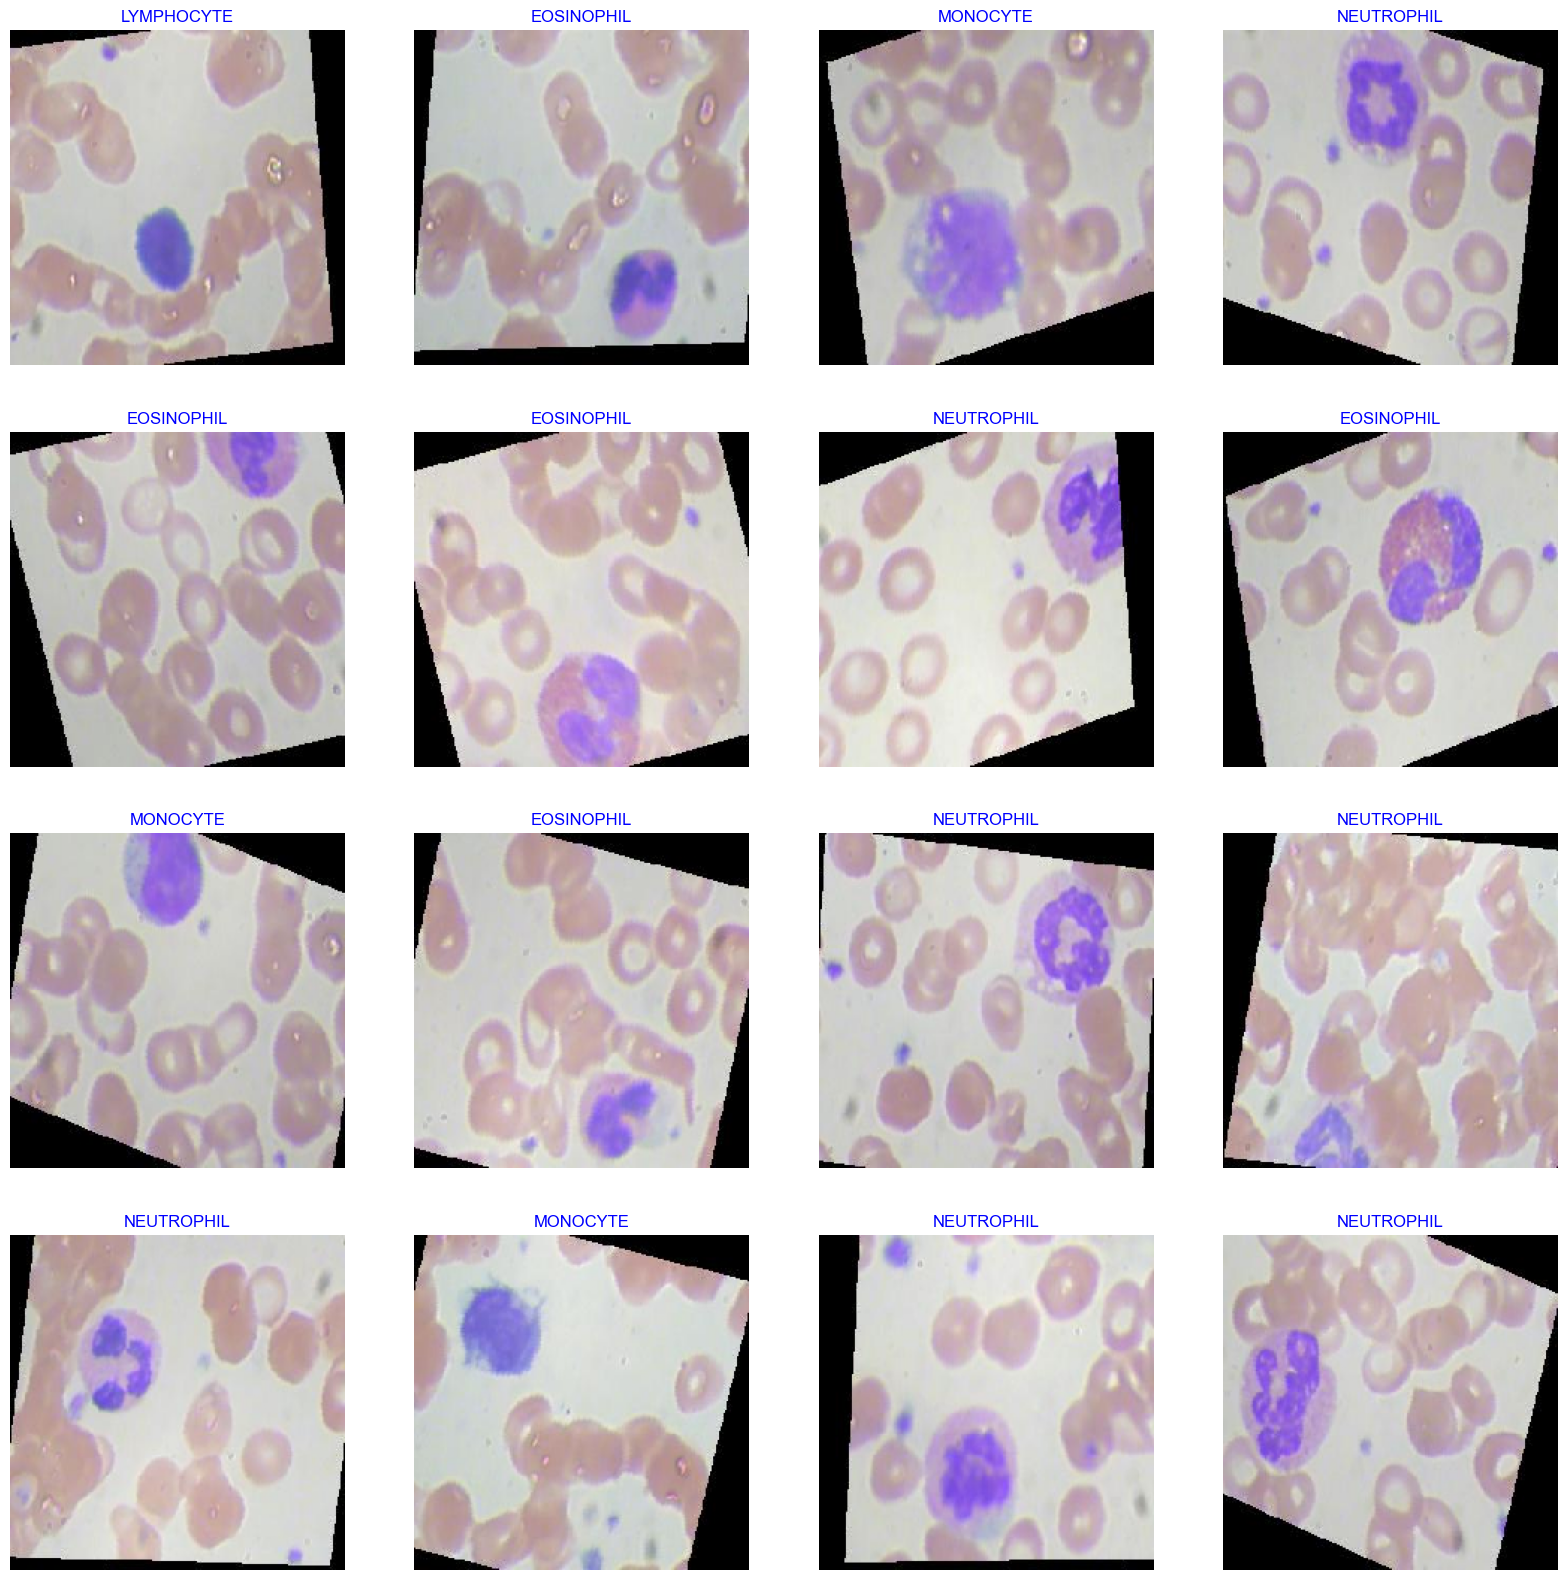

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(min(batch_size, 16)):  # Ensure the loop does not exceed the grid size (4x4)
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

# شكل الصور
img_shape = (224, 224, 3)

# عدد الفئات
class_count = len(train_gen.class_indices)

# تحميل ResNet50 بدون الرأس (include_top=False)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)

# تجميد كل الطبقات في البداية
for layer in base_model.layers:
    layer.trainable = False

# فتح آخر 10 طبقات فقط (fine-tuning)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# بناء النموذج الكامل
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # أفضل من Flatten مع ResNet
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(class_count, activation='softmax')
])

# تجميع النموذج
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# عرض ملخص النموذج
model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,476 (92.02 MB)

 Trainable params: 4,995,332 (19.06 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

In [ ]:
# عدد الـ epochs
epochs = 10

# تدريب النموذج
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    verbose=1
)



Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 566s 7s/step - accuracy: 0.5071 - loss: 1.3741 - val_accuracy: 0.6999 - val_loss: 0.7542
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 84934s 1103s/step - accuracy: 0.9286 - loss: 0.2063 - val_accuracy: 0.9062 - val_loss: 0.3044
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1054s 14s/step - accuracy: 0.9825 - loss: 0.0670 - val_accuracy: 0.9397 - val_loss: 0.1770
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 482s 6s/step - accuracy: 0.9940 - loss: 0.0317 - val_accuracy: 0.9625 - val_loss: 0.1078
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 503s 6s/step - accuracy: 0.9974 - loss: 0.0164 - val_accuracy: 0.9645 - val_loss: 0.1021
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 512s 7s/step - accuracy: 0.9979 - loss: 0.0112 - val_accuracy: 0.9806 - val_loss: 0.0683
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 493s 6s/step - accuracy: 0.9990 - loss: 0.0065 - val_accuracy: 0.9812 - val_loss: 0.0556
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9

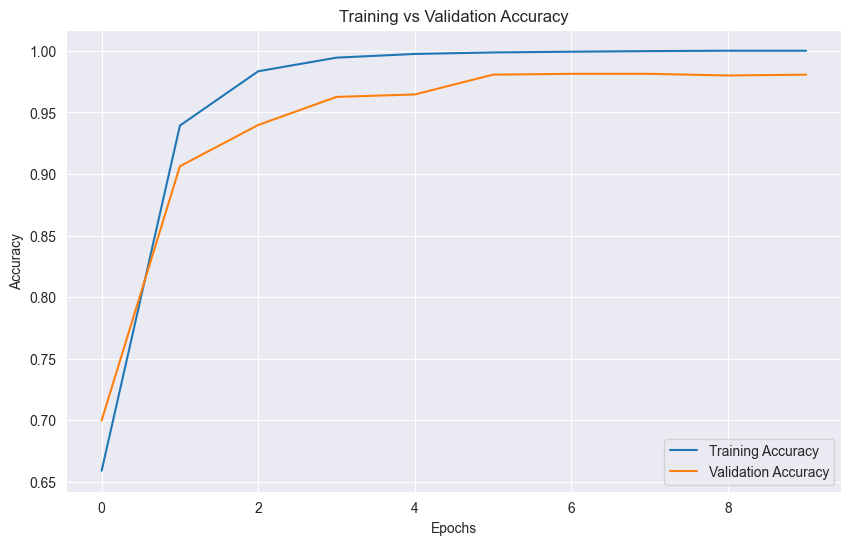

In [35]:
import matplotlib.pyplot as plt

# استخراج دقة التدريب و دقة التحقق من history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# رسم الدقة عبر الـ epochs
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9824 - loss: 0.0530

Test Accuracy: 0.9769
Test Loss: 0.0640


In [37]:
# الحصول على التوقعات من النموذج
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step


In [38]:
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

In [39]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

  EOSINOPHIL       0.98      0.95      0.96       261
  LYMPHOCYTE       0.98      1.00      0.99       240
    MONOCYTE       1.00      0.99      0.99       240
  NEUTROPHIL       0.95      0.98      0.97       255

    accuracy                           0.98       996
   macro avg       0.98      0.98      0.98       996
weighted avg       0.98      0.98      0.98       996



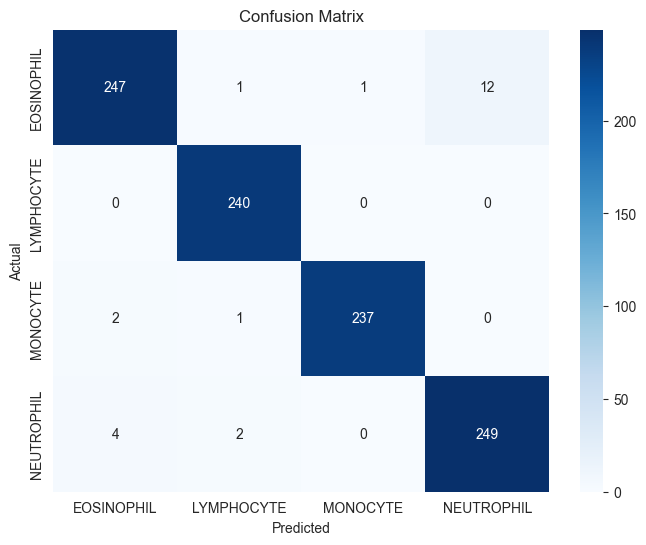

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# إنشاء مصفوفة الالتباس
cm = confusion_matrix(y_true, y_pred)

# رسم المصفوفة
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1]:
import tensorflow as tf

# تحميل نموذج .h5
model = tf.keras.models.load_model("C:/Users/LAP-STORE/Desktop/Amit/computer vesion/ResNet_model.h5")

# تحويل النموذج إلى TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# حفظ النموذج بصيغة .tflite
with open("C:/Users/LAP-STORE/Desktop/Amit/computer vesion/ResNet_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\LAP-ST~1\AppData\Local\Temp\tmp8lqllbpk\assets


INFO:tensorflow:Assets written to: C:\Users\LAP-ST~1\AppData\Local\Temp\tmp8lqllbpk\assets


Saved artifact at 'C:\Users\LAP-ST~1\AppData\Local\Temp\tmp8lqllbpk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2718069266512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069271440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069526192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069527072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069275664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069523904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069527424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069527776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069529184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718069528128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2